In [1]:
import gym
import numpy as np
import tiles3 as tc
import matplotlib.pyplot as plt

In [2]:
def argmax(q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

In [7]:
class LunarLanderTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, state):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        hor_pos = [-1, 1]
        ver_pos = [-0.47, 2.0]
        hor_speed = [-2.34, 2.50]
        ver_speed = [-2.34, 0.71]
        angle = [-4.89, 4.80]
        angular_speed = [-7.0, 6.99]
        first_leg_contact = [0.0, 1.0]
        second_leg_contact = [0.0, 1.0]
        
        values = [hor_pos, ver_pos, hor_speed, ver_speed, angle, angular_speed, first_leg_contact, second_leg_contact]
        scales = self.calculate_scales(values)

        tiles = tc.tiles(self.iht, self.num_tilings, np.multiply(scales, state))
        
        return np.array(tiles)

    def calculate_scales(self, values):
        scales = []
        for v in values:
            scales.append(self.num_tiles / (v[1] - v[0]))
        return scales

In [21]:
class SarsaAgent:
    
    num_tilings = 64
    num_tiles = 8
    iht_size = 100000 # index hash table
    
    # learning rate
    alpha = 0.3 / num_tilings
    # how often random move
    epsilon = 1
    # discount future rewards
    gamma = 0.99
    
    epsilon_decay = 0.99995
    epsilon_min = 0.1
    
    

    def __init__(self, action_space, observation_space):

        self.action_space = action_space
        
        # initialize value-function weights w
        self.w = np.zeros((action_space.n, self.iht_size))
        
        # initialize tilecoder
        self.tc = LunarLanderTileCoder(iht_size=self.iht_size, 
                                       num_tilings=self.num_tilings, 
                                       num_tiles=self.num_tiles)
        
        self.previous_tiles = None
        
        # initialize state, action and reward
        #self.s = self.a = self.r = None
    
    def select_initial_action(self, state):
        active_tiles = self.tc.get_tiles(state)
        action, action_value = self.select_action(active_tiles)
        
        self.previous_tiles = np.copy(active_tiles)
        
        return action

    def select_action(self, tiles):
        action_values = []
        action = None
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        for w in self.w:
            action_values.append(sum(w[tiles]))
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            action = np.random.randint(len(action_values))
        else:
            action = argmax(action_values)
        
        #print("tiles", tiles, "action_values", action_values)
        #print("weights", self.w)
        
        return action, action_values[action]

    def observe(self, state, action, reward, next_state, done):
            #input()
            #print("state", state, "action", action, "reward", reward, "next_state", next_state)
            if done:
                target = reward
                estimate = sum(self.w[action][self.previous_tiles])
                self.w[action][self.previous_tiles] += self.alpha * (target - estimate)
                return None
            else:
                active_tiles = self.tc.get_tiles(state)
                
                next_action, action_value = self.select_action(active_tiles)
                
                target = reward + self.gamma * action_value
                estimate = sum(self.w[action][self.previous_tiles])
                # print("loss", target - estimate)
                
                self.w[action][self.previous_tiles] += self.alpha * (target - estimate)
                
                self.previous_tiles = np.copy(active_tiles)
            
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            #print(self.epsilon)
            
            return next_action
        

Training the agent

In [23]:
env = gym.make('LunarLander-v2')
#env = env.unwrapped
agent = SarsaAgent(env.action_space, env.observation_space)

total_rewards = []

for i_episode in range(400):
    # choose inital state and action
    state = env.reset()
    action = agent.select_initial_action(state)
    total_reward = 0
    
    for t in range(1000):
        # env.render()
        # Take action and observe reward, next_state
        next_state, reward, done, info = env.step(action)
        action = agent.observe(state, action, reward, next_state, done)
        total_reward += reward
        if done:
            break
        state = next_state
    #print("Episode {} finished after {} timesteps with reward {}".format(i_episode, t+1, total_reward))
    total_rewards.append(total_reward)
    #if i_episode >= 100 and np.mean(total_rewards[-100:]) > 195:
    #    print("Solved, episode", i_episode)
    #    break
    
env.close()

np.mean(total_rewards[-100:])

IHT full, starting to allow collisions


-146.7897033237117

Plot agents performance

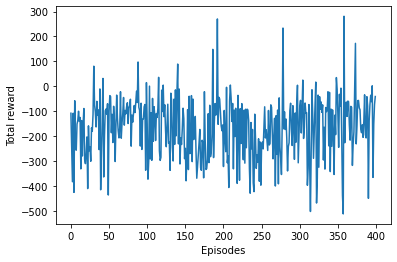

In [24]:
plt.plot(total_rewards)
plt.plot()
plt.ylabel('Total reward')
plt.xlabel('Episodes')
plt.show()

Test agent

In [25]:
total_rewards = []

for i_episode in range(10):
    # choose inital state and action
    state = env.reset()
    action = agent.select_initial_action(state)
    total_reward = 0
    
    for t in range(1000):
        env.render()
        # Take action and observe reward, next_state
        next_state, reward, done, info = env.step(action)
        action = agent.observe(state, action, reward, next_state, done)
        total_reward += reward
        if done:
            break
        state = next_state
    
    total_rewards.append(total_reward)
    print("Episode finished after {} timesteps, reward {}".format(t+1, total_reward))
    
    
np.mean(total_rewards)
    
env.close()

Episode finished after 186 timesteps, reward -57.19001958001371
Episode finished after 213 timesteps, reward -54.977096666045455
Episode finished after 155 timesteps, reward -267.5818598994411
Episode finished after 124 timesteps, reward -177.69916467701847
Episode finished after 175 timesteps, reward -55.666102406585196
Episode finished after 254 timesteps, reward -30.738166689879137
Episode finished after 202 timesteps, reward -320.6722370783434
Episode finished after 148 timesteps, reward -378.9287483036734
Episode finished after 202 timesteps, reward -94.65677350233024
Episode finished after 156 timesteps, reward -67.83775509693683


Finding value ranges for tile coder

In [88]:

env = gym.make('LunarLander-v2')
observations = []
for i_episode in range(100000):
    observation = env.reset()
    for t in range(1000):
        #env.render()
        observations.append(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
env.close()
data = np.array(observations).T
h, v, h_s, v_s, a, a_s, f_lc, s_lc = data

print("hor pos min", np.min(h), "max", np.max(h))
print("ver pos min", np.min(v), "max", np.max(v))
print("hor speed min", np.min(h_s), "max", np.max(h_s))
print("ver speed min", np.min(v_s), "max", np.max(v_s))
print("angle min", np.min(a), "max", np.max(a))
print("angular speed min", np.min(a_s), "max", np.max(a_s))
print("first leg contact", np.min(f_lc), "max", np.max(f_lc))
print("second leg contact", np.min(s_lc), "max", np.max(s_lc))



KeyboardInterrupt: 

1,000 eps
hor pos min -0.99929327 max 0.99987394
ver pos min -0.41794086 max 1.8056848
hor speed min -1.9801567 max 2.3109238
ver speed min -2.1281495 max 0.57571495
angle min -4.074976 max 3.7218862
angular speed min -5.7167087 max 5.764369
first leg contact 0.0 max 1.0
second leg contact 0.0 max 1.0

10,000 eps
hor pos min -0.9999891 max 0.99993956
ver pos min -0.4477216 max 1.8325248
hor speed min -2.2053316 max 2.3370428
ver speed min -2.3518126 max 0.5937856
angle min -4.123625 max 4.5628214
angular speed min -6.85596 max 6.8068733
first leg contact 0.0 max 1.0
second leg contact 0.0 max 1.0

100,000 eps
hor pos min -0.9999993 max 0.9999983
ver pos min -0.46811426 max 1.9977229
hor speed min -2.336575 max 2.4958823
ver speed min -2.335797 max 0.70805645
angle min -4.875486 max 4.7994423
angular speed min -7.0356493 max 6.9858065
first leg contact 0.0 max 1.0
second leg contact 0.0 max 1.0